In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import torch
import torch.nn.functional as F
import pyro

In [4]:
from torch.utils.data import DataLoader
from pyro.infer import Predictive

In [5]:
from monteloanco import model, guide, register_loan_params, build_tmat_logits, simulate_portfolio_from_samples

In [6]:
from scipy.special import logit

### Load the data and model

Here we load the subset of accounts used for training earlier and the weights into the model.

In [7]:
device = 'cuda:0'
embedding_size = 3

In [8]:
df_train = pd.read_json('training.jsonl.gz', lines=True)
pd.testing.assert_index_equal(df_train.index, pd.RangeIndex(0, len(df_train)))

In [9]:
pyro.get_param_store().load('param_store.pt')

/home/daniel/monteloanco/.venv/lib/python3.10/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_file, map_

### Transform embeddings to transition matrices and calculate probabilities of default

The next section extracts the loan embeddings from the model, and projects them into the status transition matrices so we can inspect them.

In [10]:
batch_size = 100_000
dataset = df_train[['id', 'loan_amnt', 'int_rate', 'installment', 'n_report_d', 'total_pre_chargeoff', 'last_pymnt_amnt']].to_dict(orient='records')
dataset.__getitem__(42)

{'id': 79661304,
 'loan_amnt': 10000,
 'int_rate': 7.39,
 'installment': 310.56,
 'n_report_d': 33,
 'total_pre_chargeoff': 10008.44,
 'last_pymnt_amnt': 10012.55}

In [11]:
df_tmat = pd.DataFrame()

for batch_id, batch in enumerate(DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)):
    alpha_loc, _ = register_loan_params(batch_id, torch.arange(len(batch['id'])).to(device), len(batch['id']), device)
    logits        = build_tmat_logits(alpha_loc, device)    # (batch_size, 8, 8)
    probs         = F.softmax(logits, dim=-1)

    df_tmat_new = pd.DataFrame(zip(batch['id'].tolist(), logits, probs)).reset_index()
    df_tmat_new['batch_id'] = batch_id
    df_tmat = pd.concat([df_tmat, df_tmat_new])

In [12]:
df_tmat = df_tmat.set_axis(['batch_idx', 'id', 'logits', 'probs', 'batch_id'], axis=1)
df_tmat = df_tmat.merge(df_train, on='id')

The function below takes the transition matrix for each loan and calculates the probability of that loan being in state 7 (charged off) after 12 months. Naturally, this largely negates the purpose of determining a term-independent, multi-dimensional score in the first place, but for now we just need something to conveniently rank the accounts for the purposes of illustration. Think of this as being like a traditional credit score.

In [13]:
def probs_to_score(probs):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8).to(device)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, probs)
    return score

In [14]:
df_tmat['score'] = df_tmat['probs'].apply(lambda x: probs_to_score(x)[7].item())

In [15]:
df_tmat.drop(['logits', 'probs'], axis=1).to_json('scoring.jsonl.gz', orient='records', lines=True)

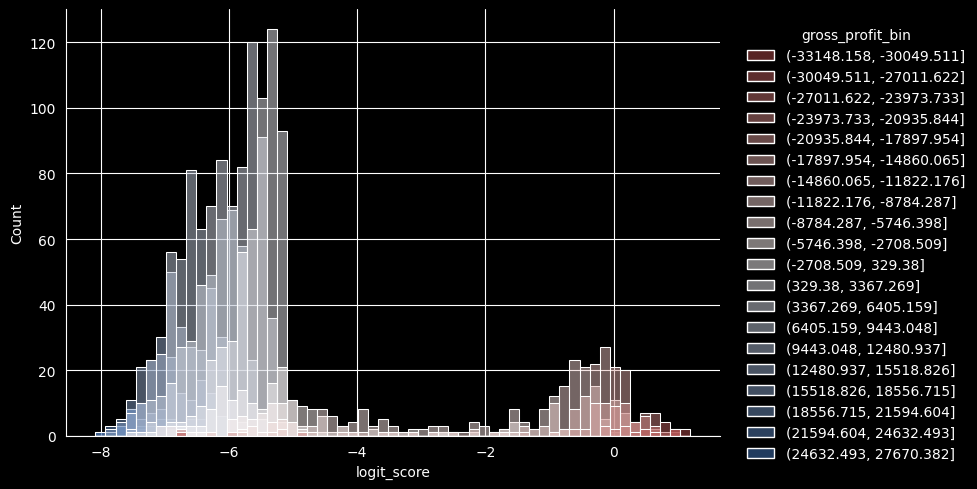

In [16]:
df_tmat.loc[df_tmat['n_report_d']>=60, 'gross_profit'] = df_tmat['total_pre_chargeoff'] - df_tmat['loan_amnt']
df_tmat["logit_score"] = logit(df_tmat["score"])
df_tmat["gross_profit_bin"] = pd.cut(df_tmat["gross_profit"], bins=20)

sns.displot(
    data=df_tmat,
    x="logit_score",
    hue="gross_profit_bin",
    kind="hist",
    palette="vlag_r",
    height=5,
    aspect=1.5
)

In [17]:
df_tmat.pymnt = df_tmat.pymnt.apply(torch.tensor)

### Inspection of best performing accounts

The 5 heatmaps reflect those accounts with the lowest probability of default. Dark red cells at `[0, 1]` indicate a high probability of transition from current to paid early, and those with dark red cells at `[1, 1]` indicate the status is likely to remain current, month after month. The transition heatmaps are followed by 50 simulations of each of these accounts and their actual cashflows which show, for these 5 accounts, this was indeed the case.

In [18]:
df_tmat_head = df_tmat.sort_values('score').head(5)

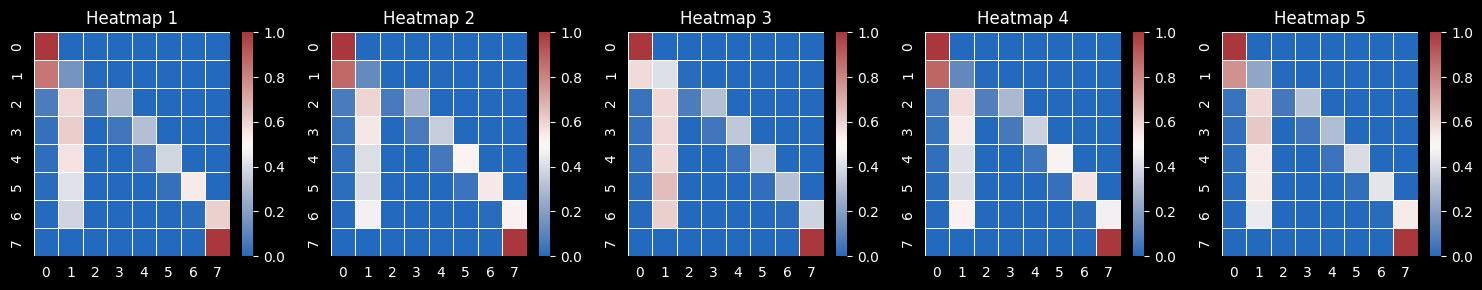

In [19]:
def plot_tmat(df_tmat, df_tmat_delta=None):

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        np_tmat = df_tmat.iloc[i].probs.cpu().detach().numpy()
        if isinstance(df_tmat_delta, pd.DataFrame):
            np_tmat = np_tmat - df_tmat_delta.iloc[i].probs.cpu().detach().numpy()
        sns.heatmap(np_tmat, ax=ax, linewidth=0.5, cmap='vlag')
        ax.set_title(f"Heatmap {i+1}")
    plt.tight_layout()
    plt.show()

plot_tmat(df_tmat_head)

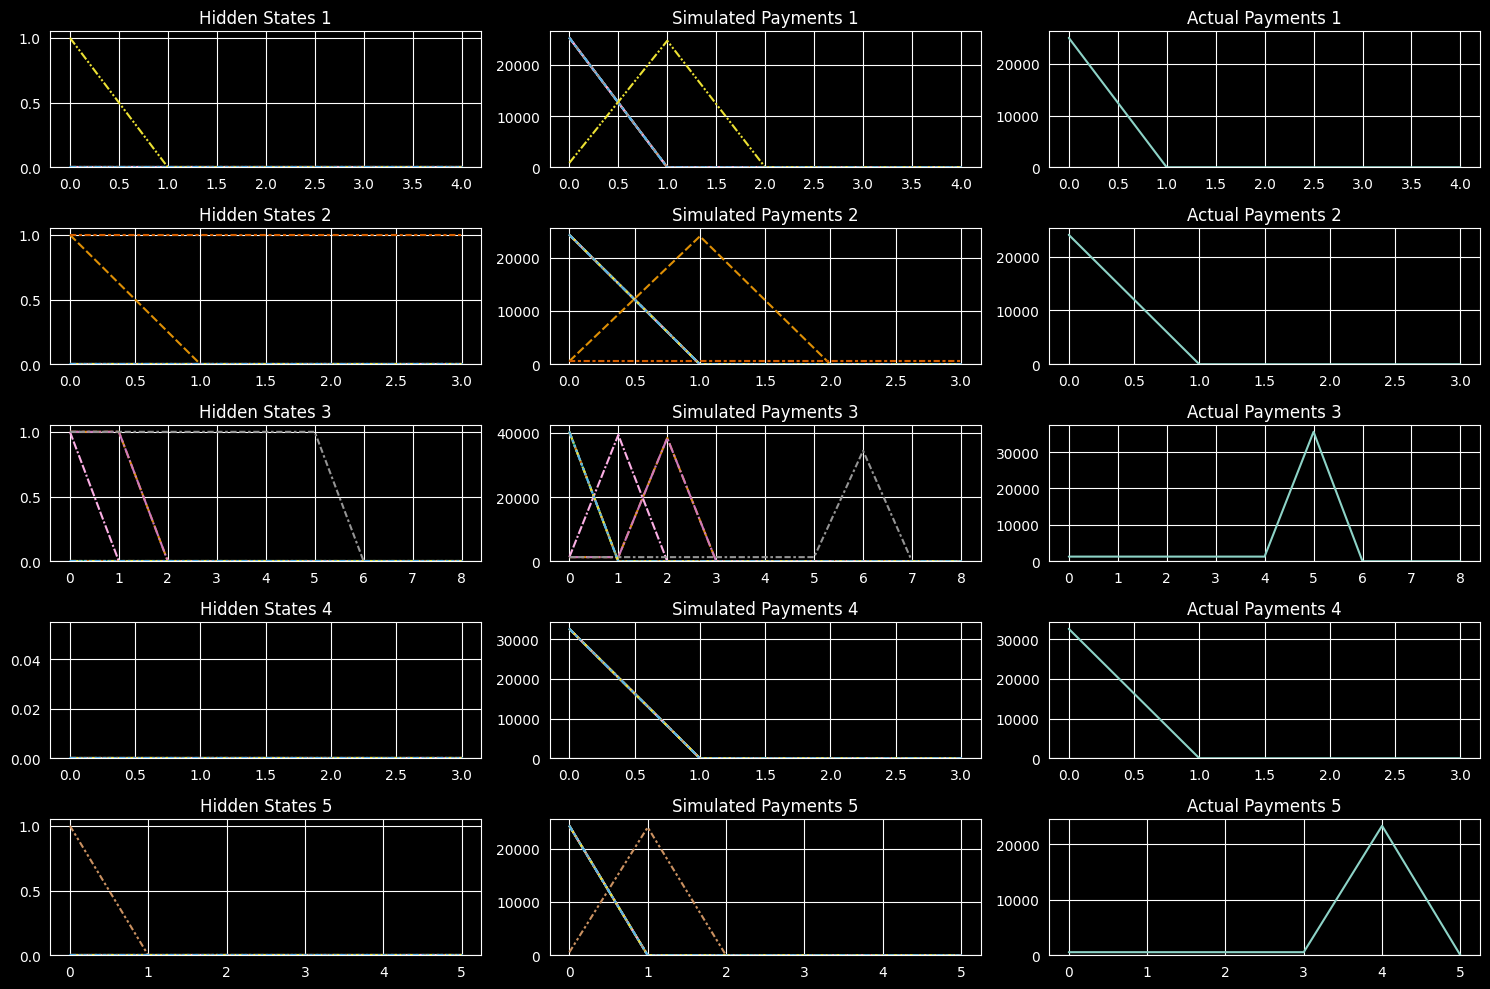

In [20]:
def plot_payments(df_tmat):

    predictive = Predictive(
        model,
        guide=guide,
        num_samples=10,
        return_sites=None,
    )

    fig, axes = plt.subplots(5, 3, figsize=(15, 10))

    for i, axs in enumerate(axes):
        loan = df_tmat.iloc[i]

        samples = predictive(
            batch_id=loan.batch_id,
            batch_idx=torch.tensor(loan.batch_idx).unsqueeze(0).to(device),
            installments=torch.tensor(loan.installment).unsqueeze(0).to(device),
            loan_amnt=torch.tensor(loan.loan_amnt).unsqueeze(0).to(device),
            int_rate=torch.tensor(loan.int_rate).unsqueeze(0).to(device),
            num_timesteps=loan.n_report_d,
            total_size=100_000,
        )

        portfolio = simulate_portfolio_from_samples(
            samples, loan, loan.batch_id, num_samples=10,
            num_timesteps=loan.n_report_d, device=device
        )

        hidden_states, sim_pymnts, interest_paid, principal_paid = portfolio.get_histories().values()

        sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
        sns.lineplot(sim_pymnts.detach().cpu().numpy(),    ax=axs[1], palette='colorblind', legend=False)
        sns.lineplot(loan.pymnt.detach().cpu().numpy(),    ax=axs[2], legend=False)
        axs[0].set_title(f"Hidden States {i+1}")
        axs[1].set_title(f"Simulated Payments {i+1}")
        axs[2].set_title(f"Actual Payments {i+1}")
        axs[0].set_ylim(0); axs[1].set_ylim(0); axs[2].set_ylim(0)

    plt.tight_layout()
    plt.show()

plot_payments(df_tmat_head)

### Inspection of worst performing accounts

The same data is then presented for the 5 accounts with the highest probability of default. These heatmaps are characterised by deep red cells at `[7, 6]`, indicating a high probability of defaulting. In paractice it's not possible to transition directly from state 1 to state 7, and you see here how the cells one step off-diagonal to the right are highly probable, illustrating how the delinqency states slowly escalate. Further below, in contrast to the simulations above, most simulations here are rapidly transitioning to state 7 (charge-off) from where they no longer yield any payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as all these accounts are charged off before long they reached full term.

In [21]:
df_tmat_tail = df_tmat.sort_values('score').tail(5)

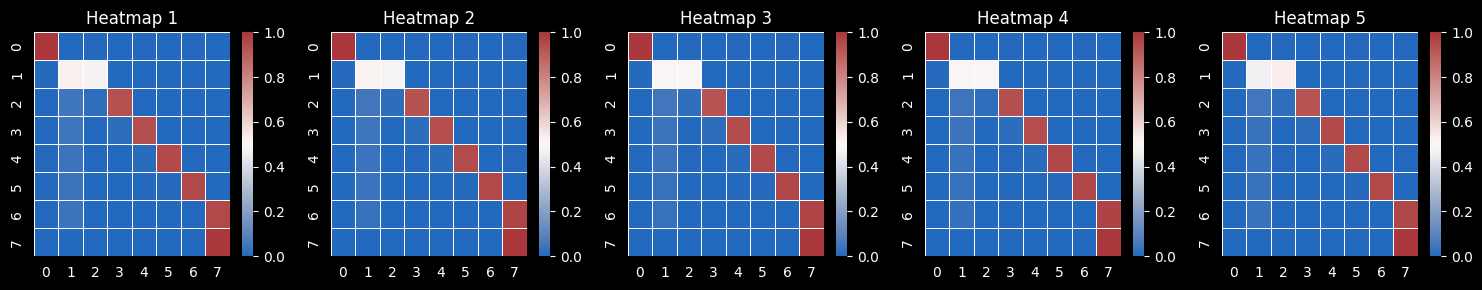

In [22]:
plot_tmat(df_tmat_tail)

And, in similar contast to the simulations above, most simulations here are rapidly transitioning to state 7 (charge-off) from where they no longer yield any payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as all these accounts are charged off befor ethey reached full term.

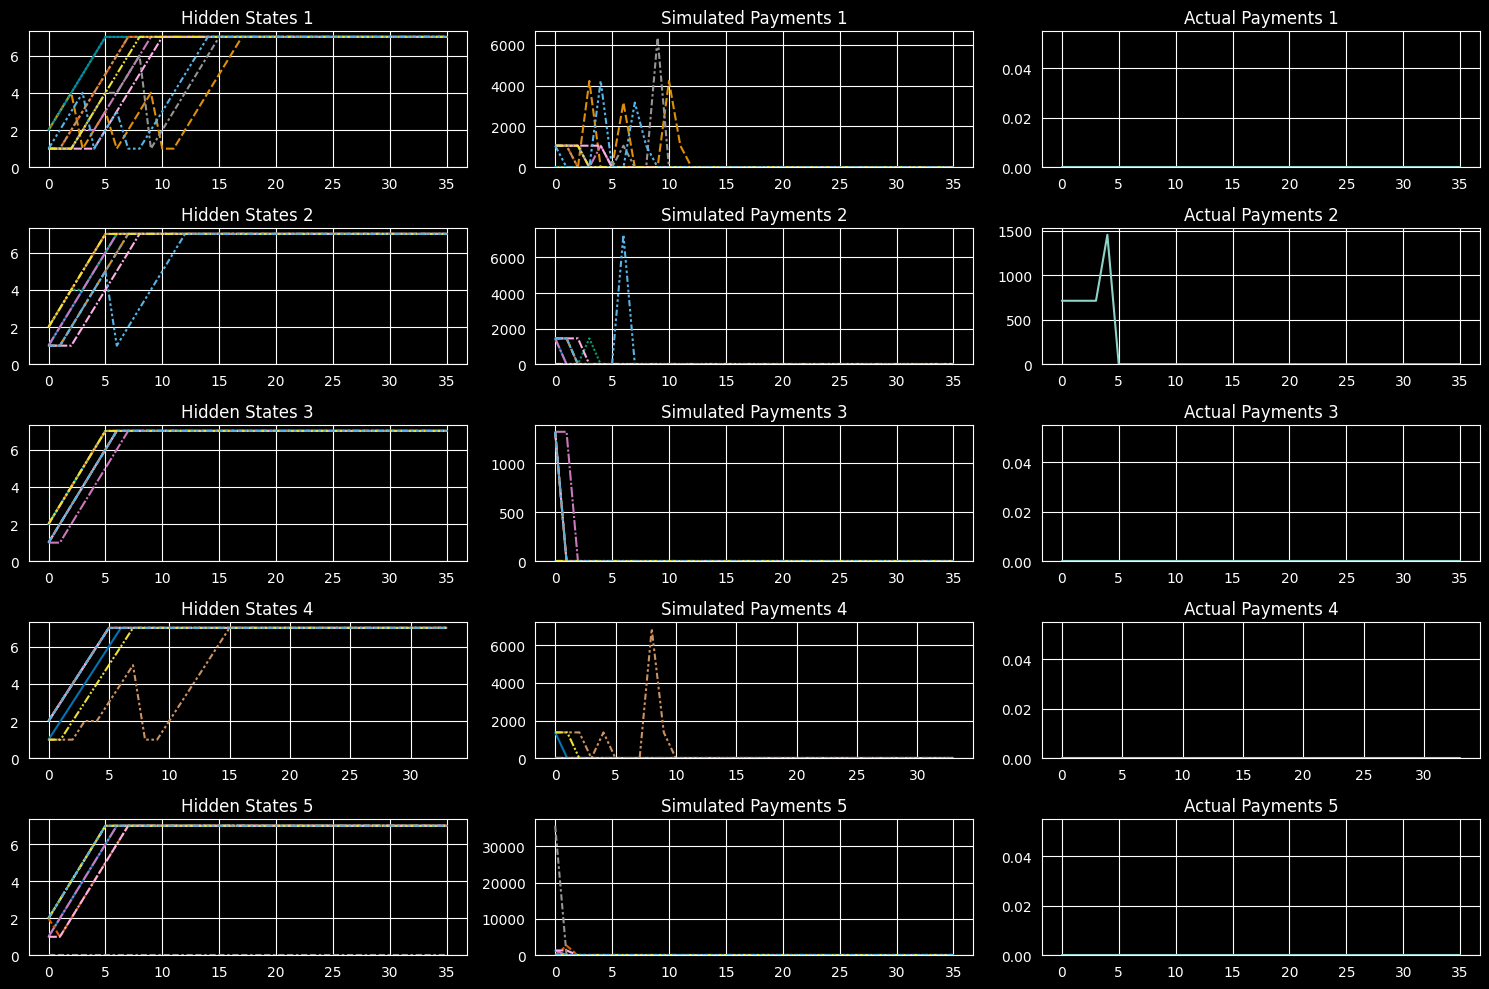

In [23]:
plot_payments(df_tmat_tail)

### Transition matrix deltas

The differences between the highest and lowest scoring accounts' heatmaps can finally be seen below. The blue cells in column 1 illustrate those accounts remaining up to date (or catching up where they are late) and the red cells in column 7 indicates those accounts being charged off.

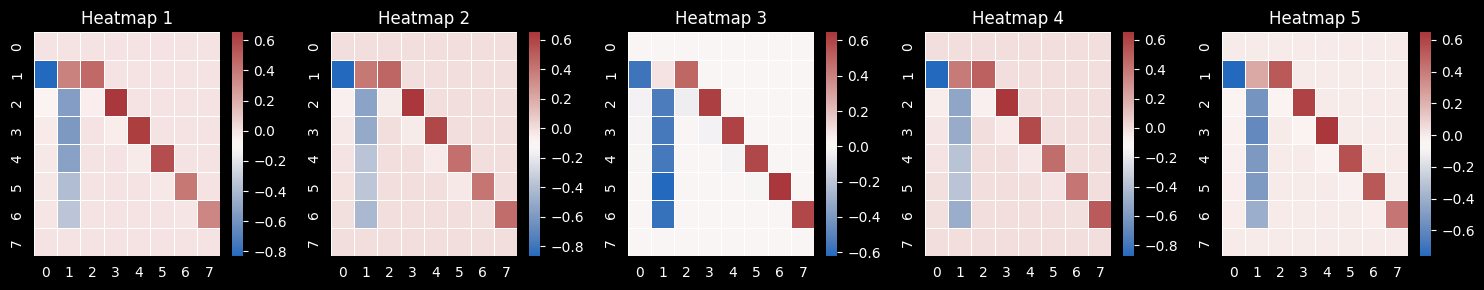

In [24]:
plot_tmat(df_tmat_tail, df_tmat_head)

In [25]:
pyro.get_param_store().keys()

dict_keys(['0_alpha_loc', '0_alpha_scale'])

In [26]:
pyro.get_param_store()['0_alpha_loc']

tensor([[[ 7.3351e-03, -2.8111e-03,  4.7922e-04,  ..., -7.1197e-03,
          -5.6917e-04,  2.0283e-04],
         [-1.5038e+00,  1.7749e+00, -2.8076e-01,  ...,  4.9346e-03,
          -6.1950e-03, -1.4389e-02],
         [-3.1725e-02,  9.0288e-02,  1.1814e-02,  ..., -3.5051e-03,
           4.0011e-03,  7.7209e-03],
         ...,
         [-2.0856e-02,  5.6202e-02, -1.2463e-02,  ..., -1.6891e-02,
          -1.6635e-02,  2.1649e-03],
         [ 1.2780e-02,  3.2872e-02, -6.6379e-03,  ..., -2.9237e-03,
           1.2795e-02, -4.2865e-02],
         [-1.1526e-03,  8.9991e-03, -1.1975e-02,  ...,  8.7524e-03,
           2.3732e-02,  6.3721e-03]],

        [[ 1.0188e-02,  1.5089e-02,  3.2555e-03,  ...,  7.8970e-03,
          -3.3957e-03, -7.0724e-04],
         [ 6.6874e-01, -4.7187e-01, -1.9134e-01,  ...,  3.6445e-03,
           1.5818e-03,  4.5009e-05],
         [ 7.0451e-03,  8.7314e-02, -2.2248e-02,  ...,  5.7188e-03,
          -9.5751e-03, -2.9776e-02],
         ...,
         [ 1.5605e-02,  1

In [27]:
pyro.get_param_store()['0_alpha_scale']

tensor([[[0.1631, 0.1617, 0.1702,  ..., 0.1667, 0.1661, 0.1655],
         [0.0854, 0.1099, 0.1596,  ..., 0.1649, 0.1650, 0.1689],
         [0.1691, 0.1543, 0.1667,  ..., 0.1696, 0.1631, 0.1677],
         ...,
         [0.1626, 0.1703, 0.1676,  ..., 0.1608, 0.1606, 0.1703],
         [0.1681, 0.1642, 0.1622,  ..., 0.1657, 0.1595, 0.1657],
         [0.1681, 0.1699, 0.1667,  ..., 0.1669, 0.1665, 0.1675]],

        [[0.1733, 0.1729, 0.1768,  ..., 0.1689, 0.1757, 0.1722],
         [0.0994, 0.0966, 0.1511,  ..., 0.1706, 0.1709, 0.1674],
         [0.1725, 0.1727, 0.1783,  ..., 0.1719, 0.1716, 0.1730],
         ...,
         [0.1698, 0.1658, 0.1731,  ..., 0.1690, 0.1801, 0.1727],
         [0.1686, 0.1861, 0.1694,  ..., 0.1737, 0.1748, 0.1622],
         [0.1711, 0.1709, 0.1759,  ..., 0.1682, 0.1768, 0.1699]],

        [[0.2161, 0.2211, 0.2196,  ..., 0.2227, 0.2202, 0.2177],
         [0.1189, 0.1243, 0.1881,  ..., 0.2175, 0.2218, 0.2169],
         [0.2101, 0.2137, 0.2144,  ..., 0.2143, 0.2161, 0.